In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import SmoothingFunction
import nltk
from nltk import word_tokenize
#nltk.download('wordnet')

In [4]:
devset = pd.read_csv("data/dev_set.csv").astype(str)
devset

,question,answer,text,paragraph,law
0,"Hvad har ejeren af en ejerlejlighed, sammen me...","Grunden, fælles bestanddele og tilbehør",'Ejeren af en ejerlejlighed har sammen med and...,3,LOV nr 908 af 18/06/2020
1,Hvem fastsætter eller aftaler bestemmelser om ...,Finansministeren fastsætter eller aftaler best...,'Højskolen skal følge de af finansministeren f...,30,LBK nr 780 af 08/08/2019
2,Hvad skal Beskæftigelsesministeriet og Finanst...,Den indsendte årsrapport skal i det mindste in...,'Uden ugrundet ophold efter repræsentantskabet...,25 l,LBK nr 1110 af 10/10/2014
3,Hvor mange procent må kapitalandele i og lån y...,Kapitalandele i og lån ydet til en virksomhed ...,'Følgende grænser for Arbejdsmarkedets Tillægs...,26 e,LBK nr 1110 af 10/10/2014
4,Hvad er en betingelse for retten til jobpræmie?,Det er en betingelse for retten til jobpræmie ...,'Det er en betingelse for retten til jobpræmie...,9,LOV nr 287 af 29/03/2017
...,...,...,...,...,...
101,Hvordan anføres kandidatlister på stemmesedler?,I særskilte felter.,Kandidatlisterne anføres på stemmesedlen i sær...,46,LBK nr 6 af 08/01/2024
102,Hvem iværksætter beslaglæggelse?,Politiet.,Politiet iværksætter beslaglæggelse. Politiet ...,807,LBK nr 250 af 04/03/2024
103,Hvis interesser skal foranstaltninger mod inte...,De forvaltede alternative investeringsfondes e...,En forvalter af alternative investeringsfonde ...,23,LBK nr 231 af 01/03/2024
104,Hvad skal valgstyrere eller tilforordnede vælg...,At stemmekasserne er tomme.,Afstemningen begynder kl. Inden stemmeafgivnin...,38,LBK nr 1432 af 01/12/2023


In [5]:
answers = devset['question'].tolist() # we will just use this for now
gold_answers = devset['answer'].tolist()

In [23]:
# eval functions
def calculate_bleu(answers, gold_answers):
    scores = []
    for answer, gold_answer in zip(answers, gold_answers):
        score = sentence_bleu([gold_answer], answer, smoothing_function=SmoothingFunction().method1)
        scores.append(score)
    return scores

def calculate_rouge(answers, gold_answers):
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    for answer, gold_answer in zip(answers, gold_answers):
        scores = scorer.score(answer, gold_answer)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
        
    return rouge1_scores, rouge2_scores, rougeL_scores

def calculate_meteor(answers, gold_answers):
    scores = []
    for answer, gold_answer in zip(answers, gold_answers):
        answer_tokens = answer.split()
        gold_answer_tokens = gold_answer.split()
        score = meteor_score([gold_answer_tokens], answer_tokens, gamma=0.0)
        scores.append(score)
    return scores

# avg scores
def calculate_avg_scores(answers, gold_answers):
    bleu_scores = calculate_bleu(answers, gold_answers)
    rouge1_scores, rouge2_scores, rougeL_scores = calculate_rouge(answers, gold_answers)
    meteor_scores = calculate_meteor(answers, gold_answers)
    return np.mean(bleu_scores), np.mean(rouge1_scores), np.mean(rouge2_scores), np.mean(rougeL_scores), np.mean(meteor_scores)

# function to evalualate answers from different models
def evaluate_answers(model_answers_list, gold_answers):
    """
    Evaluates multiple models' answers against gold answers using various metrics
    
    Args:
        model_answers_list: List of lists, where each inner list contains answers from one model
        gold_answers: List of gold/reference answers
    
    Returns:
        Dictionary of scores for each model
    """
    results = {}
    for i, answers in enumerate(model_answers_list):
        bleu_avg, rouge1_avg, rouge2_avg, rougeL_avg, meteor_avg = calculate_avg_scores(answers, gold_answers)
        results[f'model_{i+1}'] = {
            'BLEU': bleu_avg,
            'ROUGE-1': rouge1_avg, 
            'ROUGE-2': rouge2_avg,
            'ROUGE-L': rougeL_avg,
            'METEOR': meteor_avg
        }
    return results

In [24]:
# test using column 1 as gold answers and the rest as model answers
results = evaluate_answers([devset.iloc[:, 0].values.tolist(), 
                            devset.iloc[:, 1].values.tolist(), 
                            devset.iloc[:, 2].values.tolist(), 
                            devset.iloc[:, 3].values.tolist(), 
                            devset.iloc[:, 4].values.tolist()], gold_answers)
results

{'model_1': {'BLEU': 0.14837501967372502,
  'ROUGE-1': 0.1296237287189355,
  'ROUGE-2': 0.06571031837738553,
  'ROUGE-L': 0.11504367204259942,
  'METEOR': 0.11827223323716245},
 'model_2': {'BLEU': 0.9958711445772674,
  'ROUGE-1': 1.0,
  'ROUGE-2': 0.8301886792452831,
  'ROUGE-L': 1.0,
  'METEOR': 1.0},
 'model_3': {'BLEU': 0.20624942188344925,
  'ROUGE-1': 0.2864677602952512,
  'ROUGE-2': 0.24936631824412223,
  'ROUGE-L': 0.2850876380821486,
  'METEOR': 0.44447349787655266},
 'model_4': {'BLEU': 0.007021642702280796,
  'ROUGE-1': 0.009433962264150943,
  'ROUGE-2': 0.0,
  'ROUGE-L': 0.009433962264150943,
  'METEOR': 0.00976953507504466},
 'model_5': {'BLEU': 0.012685833402457583,
  'ROUGE-1': 0.022955799905433935,
  'ROUGE-2': 0.0,
  'ROUGE-L': 0.02281499449850631,
  'METEOR': 0.02131926490732569}}

In [25]:
def plot_model_scores(results, metrics=None, titles=None):

    # if metrics is None, use all available metrics
    if metrics is None:
        metrics = list(next(iter(results.values())).keys())
    
    filtered_results = {
        model: {metric: score for metric, score in scores.items() if metric in metrics}
        for model, scores in results.items()
    }

    # y axis max value
    max_value = max(max(scores.values()) for scores in filtered_results.values())

    # grid dimensions
    n_models = len(filtered_results)
    n_cols = int(np.ceil(np.sqrt(n_models)))
    n_rows = int(np.ceil(n_models / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
    axes = axes.ravel()

    # plot each model
    for idx, (model, scores) in enumerate(filtered_results.items()):
        ax = axes[idx]
        ax.bar(scores.keys(), scores.values())
        title = titles[idx] if titles and idx < len(titles) else f'Model {model}'
        ax.set_title(title)
        ax.tick_params(axis='x')
        ax.set_ylim(0, max_value * 1.1)
    
    # hide any empty subplots
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

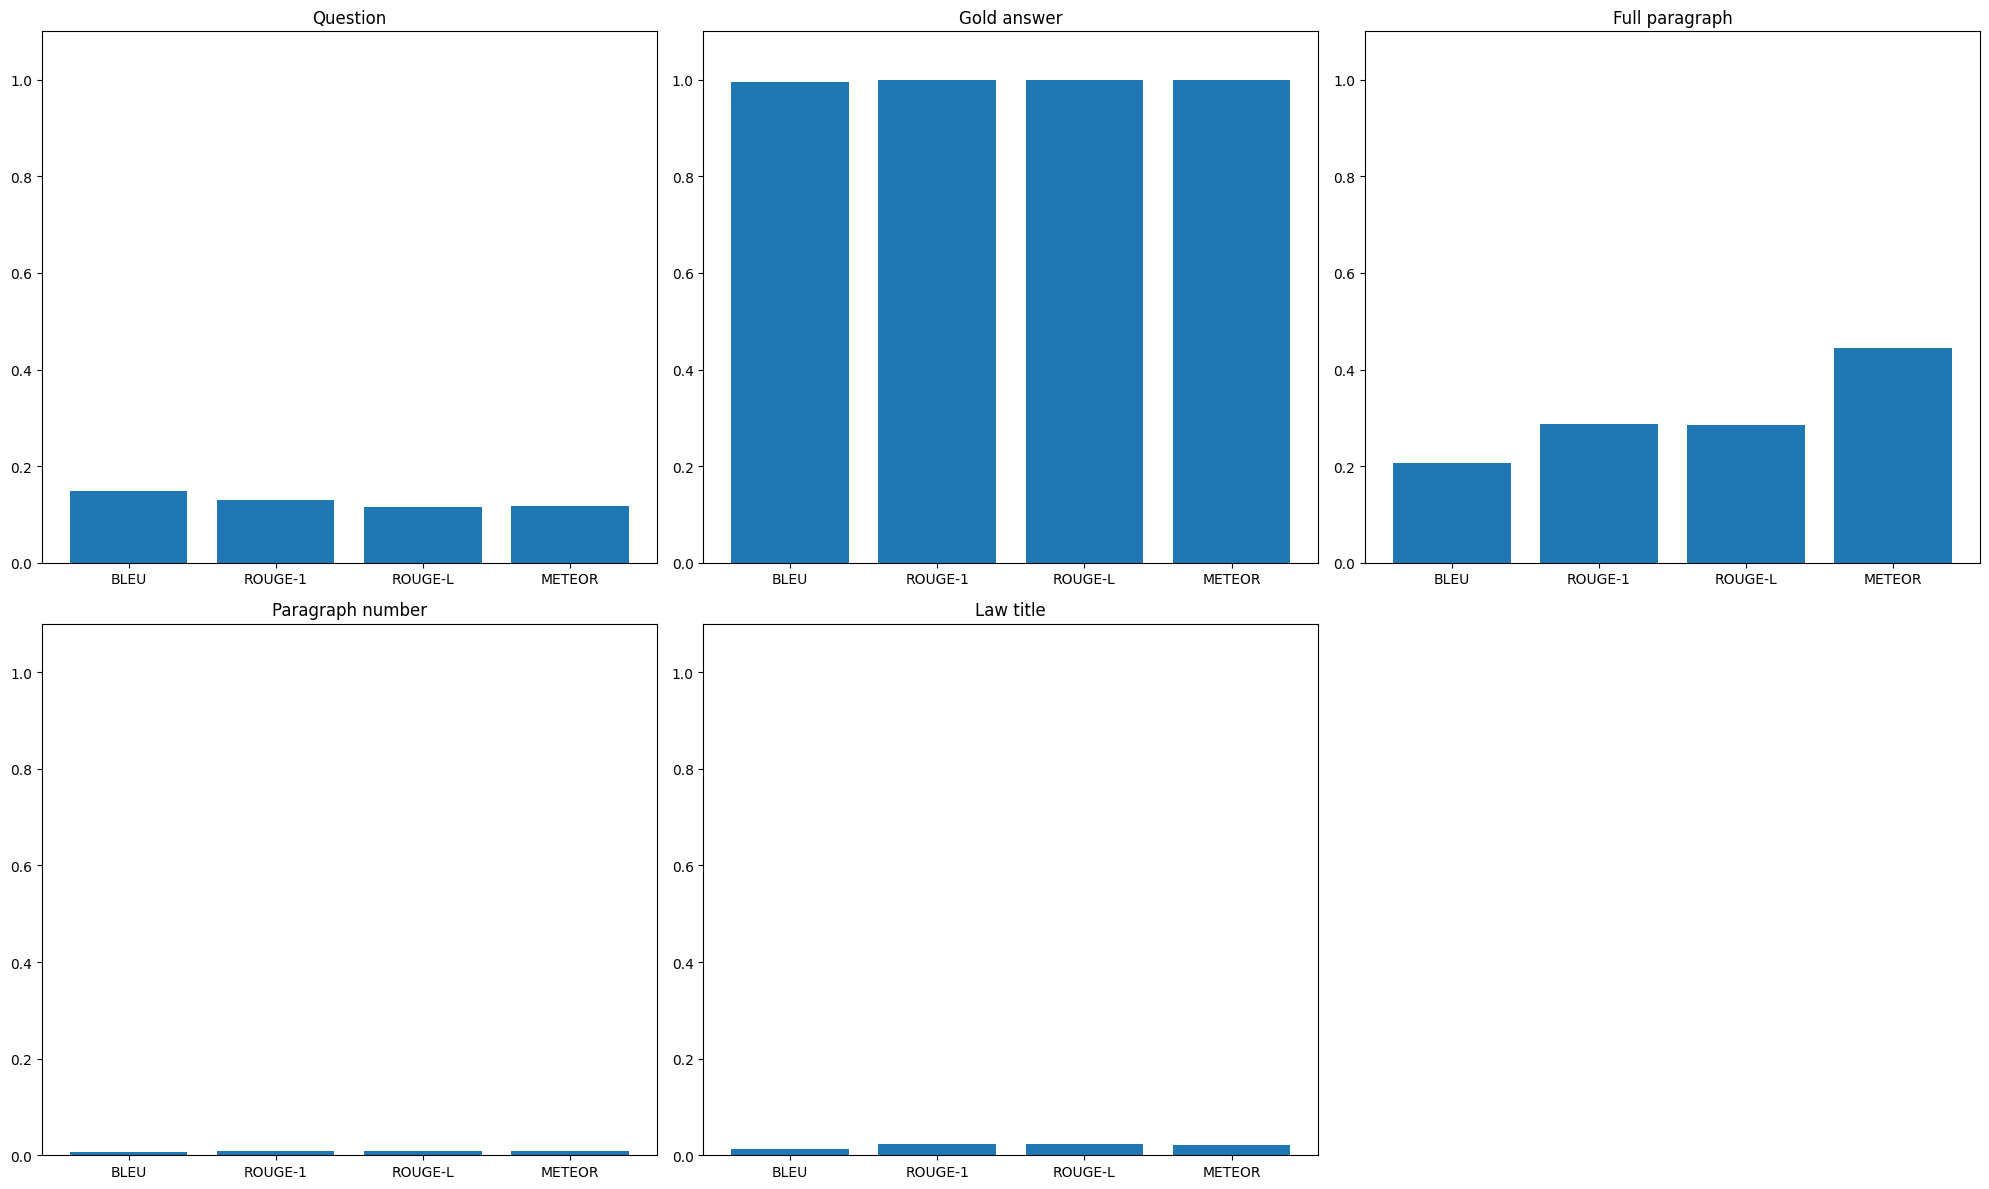

In [26]:
plot_model_scores(results, metrics=['BLEU', 'ROUGE-1', 'ROUGE-L', 'METEOR'], titles = ['Question', 'Gold answer', 'Full paragraph', 'Paragraph number', 'Law title'])

___

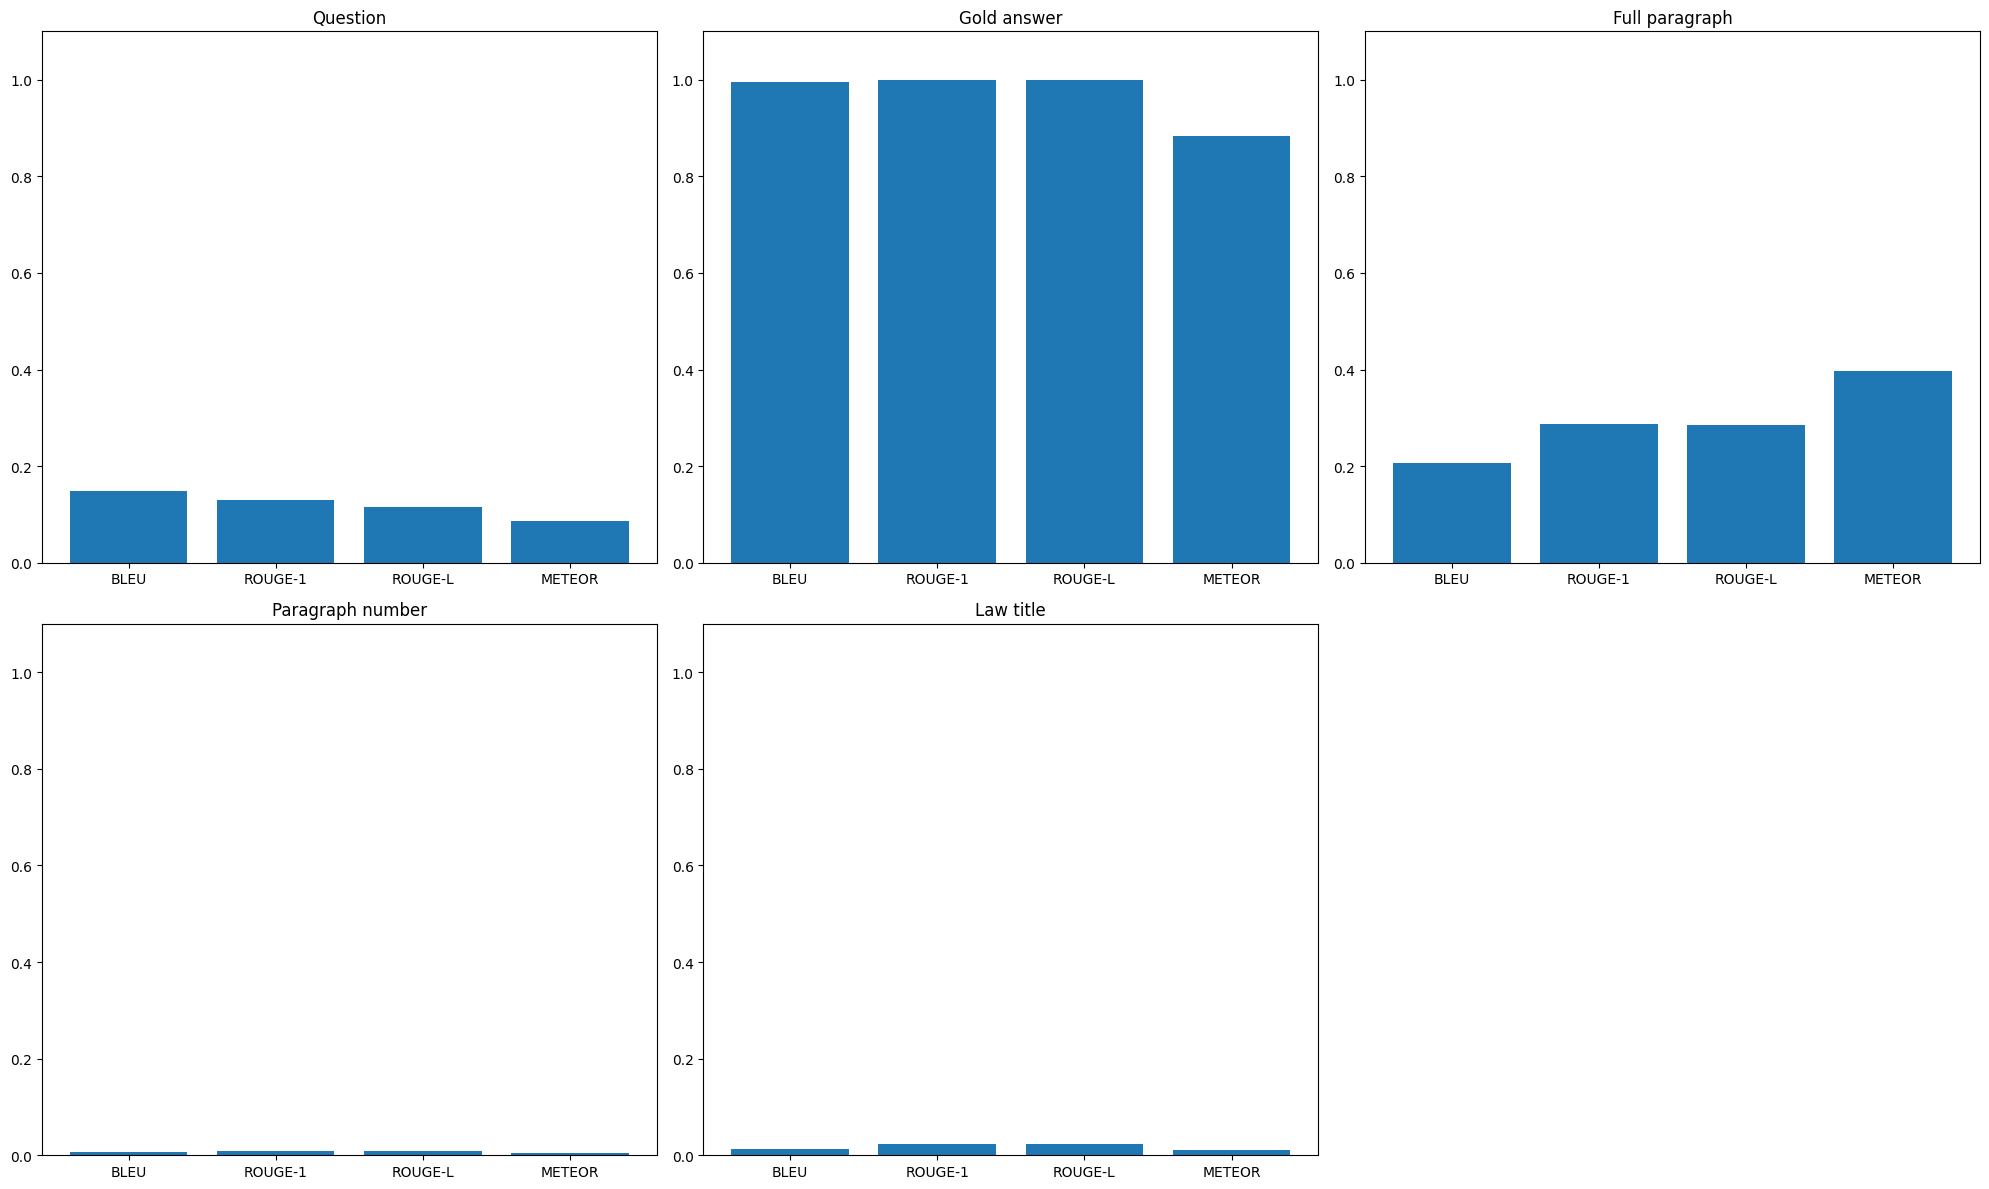

In [87]:
# run eval functions from utils/eval_functions.py
from utils.eval_functions import *

results = evaluate_answers([devset.iloc[:, 0].values.tolist(), 
                            devset.iloc[:, 1].values.tolist(), 
                            devset.iloc[:, 2].values.tolist(), 
                            devset.iloc[:, 3].values.tolist(), 
                            devset.iloc[:, 4].values.tolist()], gold_answers)

plot_model_scores(results, metrics=['BLEU', 'ROUGE-1', 'ROUGE-L', 'METEOR'], titles = ['Question', 'Gold answer', 'Full paragraph', 'Paragraph number', 'Law title'])